# **Lezione 12**

### **Esercizio 12.1 - DNN**

L’obiettivo dell’esercizio 12.1 è addestrare e ottimizzare una rete neurale profonda (DNN) per il riconoscimento di cifre scritte a mano, utilizzando il dataset MNIST. Il dataset MNIST contiene 70.000 immagini in scala di grigi di dimensione $28 \times 28$ pixel, per un totale di 784 pixel per ogni immagine, con valori di intensità compresi tra 0 (bianco) e 255 (nero). I dati sono suddivisi in 60.000 esempi di training e 10.000 esempi di test, già predefiniti.

L’esercizio prevede i seguenti obiettivi principali:

+ Caricare e preprocessare i dati in modo che siano compatibili con l’input di una rete neurale.

+ Costruire una rete neurale profonda utilizzando il modello Sequential di Keras, un’adeguata funzione di attivazione, testando diversi ottimizzatori e loss functions.

+ Allenare il modello su più epoche, monitorando l’evoluzione dell’accuratezza e della funzione di costo su training e validation set.

##### **Formattazione dei dati**

Lo script seguente prepara il dataset MNIST per l'allenamento della rete neurale.

Il codice carica il dataset già suddiviso in insieme di addestramento (60.000 immagini) e insieme di test (10.000 immagini). Le immagini, inizialmente rappresentate come matrici $28\times28$, vengono rimodellate in vettori di 784 elementi (per poterle usare in una DNN). I valori dei pixel, originariamente interi tra 0 e 255, vengono normalizzati in numeri decimali tra 0 e 1, per facilitare l’apprendimento della rete neurale.

Infine, anche le etichette numeriche (es. 0, 1, 2…) vengono convertite in un vettore di 0, tranne nel posto corrispondente all'etichetta dove si mette un 1. 
$$
\text{Etichetta = "3"}  \longrightarrow [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] 
$$
Questo formato è richiesto dalla loss function *categorical_crossentropy*, che userò.

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # usa solo CPU

import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape before reshaping:', X_train.shape)
print('Y_train shape before reshaping:', Y_train.shape)
print()

labels = np.array([0, 2, 1, 2, 0])
keras.utils.to_categorical(labels)

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape after reshaping:', X_train.shape)
print('X_test shape after reshaping:', X_test.shape)

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

X_train shape before reshaping: (60000, 28, 28)
Y_train shape before reshaping: (60000,)

X_train shape after reshaping: (60000, 784)
X_test shape after reshaping: (10000, 784)


##### **Scelta dell'otimizzatore**

Come richiesto dall'esercizio ho provato diversi ottimizzatori, con cui ho compilato la neural network fornita alla consegna. Tutti quanti i modelli sono stati allenati per lo stesso numero di epoche (30) e loss function. Segue dunque un elenco dei vari ottimizzatori con la loro definizione, o una breve spiegazione del loro funzionamento, il valore finale di loss e accuratezza della precisione, e un grafico della loss in funzione delle epoche.   
    
<div style="width: 48%; float: left;">

<br>    
    
**SGD**   

 L’idea di base è minimizzare la loss function aggiornando iterativamente i pesi del modello in direzione opposta al gradiente locale. In sostanza:
 * Seleziona randomicamente degli esempi di training.
 * Calcola il gradiente della loss rispetto ai pesi del modello usando solo questi esempi.
 * Aggiorna i pesi introducendo un rumore (determinato dal learning rate) nella direzione che riduce la loss, permettendo di muoversi più velocemente nello spazio dei parametri.

 Nel caso specifico della nostra rete neurale, SGD ha dato dei buoni risultati. Per quanto riguarda l'andamento della loss nelle epoche:
    
 $$
 \text{Test loss} = 0.0661 \hspace{1cm}\text{Test accuracy:} = 0.9801
 $$

</div>
<div style="width: 48%; float: right;">
    
<br>    
    
<div style="text-align: center;">
  <img src="loss_optimizers/SGD.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

<div style="width: 48%; float: left;">

**RMSprop**   

Invece di usare sempre lo stesso learning rate per aggiornare tutti i pesi, RMSprop lo adatta automaticamente per ogni singolo peso.   
Lo fa tenendo traccia di quanto grandi sono stati recentemente i cambiamenti (gradienti) per quel peso, calcolando una media “scorrevole” dei quadrati dei gradienti:
* Se un peso ha avuto gradienti molto grandi, RMSprop riduce il passo per quel peso, così gli aggiornamenti non diventano troppo violenti.
* Se invece i gradienti sono piccoli, RMSprop lascia il passo più grande, permettendo aggiornamenti più importanti.

Nel caso specifico della nostra rete neurale, RMSprop non ha performato bene, infatti osservando l'andamento della loss, questa non converge (overfitting):
    
$$
\text{Test loss} = 0.2711 \hspace{1cm}\text{Test accuracy:} = 0.9790
$$

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/RMSprop.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

<div style="width: 48%; float: left;">

**Adam**   

Adam si può considerare una sorta di “evoluzione” dell’algoritmo di discesa del gradiente. La sua forza principale sta nel combinare due idee fondamentali: l’adattività del learning rate e l’uso del momento. 
* Il momento tiene conto della storia passata dei gradienti, non solo del valore attuale. In pratica, si introduce una sorta di “inerzia” che smorza le oscillazioni e accelera la convergenza.
* In Adam, questo concetto viene espanso: l’ottimizzatore calcola due momenti distinti per ogni parametro, il primo è media mobile dei gradienti e il secondo momento è la media mobile dei quadrati dei gradienti

Nel complesso Adam ha prodotto una buona accuracy, mentre lo stesso non si può dire per l'andamento della loss, che non converge:
    
$$
\text{Test loss} = 0.1489 \hspace{1cm}\text{Test accuracy:} = 0.9818
$$

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/Adam.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

<div style="width: 48%; float: left;">

**Adagrad**   

Il funzionamento di questo optimizer è abbastanza semplice:
+ All’inizio, tutti i pesi imparano con lo stesso passo.
+ Ma man mano che l’allenamento va avanti, Adagrad tiene conto di tutti i gradienti passati (cioè quanto ogni peso è stato corretto).
+ Se un peso ha già ricevuto molti aggiornamenti grandi, Adagrad rallenta l’apprendimento per quel peso.
+ Se invece un peso ha ricevuto pochi aggiornamenti, continua ad aggiornarlo più velocemente.


Nel caso specifico della nostra rete neurale, Adagrad ha un andamento della loss di training e di test normale, ma entrambe convergono a valori più alti rispetto agli altri optimizers. Inoltre anche l'accuracy è più bassa:
    
$$
\text{Test loss} = 0.1772 \hspace{1cm}\text{Test accuracy:} = 0.9477
$$
</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/adagrad.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

<div style="width: 48%; float: left;">

**Adadelta**   

Adadelta è un ottimizzatore che nasce per risolvere un problema di Adagrad: cioè il fatto che in Adagrad il learning rate diventa sempre più piccolo col tempo, fino quasi a fermare l’apprendimento (come si può osservare nel suo grafico).
Rispetto ad Adagrad, non somma tutti i gradienti passati all’infinito, ma tiene solo una media "a breve termine" dei gradienti recenti.

Nel nostro caso Adadelta si è comportato come aspettato, loss e accuratezza stanno convergendo, ma molto lentamente. Infatti nel range di epoche date i valori non sembrano aver raggiunto ancora un plateau:
    
$$
\text{Test loss} = 0.4499 \hspace{1cm}\text{Test accuracy:} = 0.8912
$$

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/adadelta.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

<div style="width: 48%; float: left;">

**Adamax**   

Adamax è una variante di Adam, pensata per essere più stabile quando i gradienti sono molto grandi o hanno una norma elevata. Adamax è basato sulla norma infinita (cioè il massimo valore assoluto) dei gradienti, invece della media dei quadrati come in Adam. Questo lo rende più robusto a valori estremi e fluttuazioni nei gradienti.

Nel caso specifico della nostra rete neurale, ha prodotto un buon andamento di loss e accuracy, in maniera paragonabile a SGD:
    
$$
\text{Test loss} = 0.06457 \hspace{1cm}\text{Test accuracy:} = 0.9842
$$

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/adamax.png" width="500">
</div>
</div>
<div style="clear: both;"></div>


<div style="width: 48%; float: left;">

**Nadam**   

Nadam, proprio come Adam è essenzialmente RMSprop con momentum. In particolare Nadam è Adam con momentum di Nesterov.

Rispetto al momento standard il momento di Nesterov fa prima un passo anticipato nella direzione del momento accumulato e poi calcola il gradiente in quel punto, garantendo convergenza più stabile e veloce.

Data la somiglianza del metodo ad Adam vediamo che ha un andamento molto simile:
    
$$
\text{Test loss} = 0.1911 \hspace{1cm}\text{Test accuracy:} =  0.9791
$$

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/nadam.png" width="500">
</div>
</div>
<div style="clear: both;"></div>


##### **Sperimentazione con Adam**

Anche se avrei potuto considerare concluso il lavoro a questo punto, ho deciso di approfondire ulteriormente l’analisi degli ottimizzatori. In particolare, ho scelto di proseguire con l’ottimizzatore Adam. Ho quindi continuato a sperimentare e modificare i suoi parametri per valutarne l’impatto sulle prestazioni del modello e ottimizzare ulteriormente il processo di apprendimento.

<div style="width: 48%; float: left;">

<br>    
    
**Modifica del learning rate**   

Come prima modifica ho provato ad abbassare il learning rate di Adam, portandolo dallo standard $10^{-3}$ a $10^{-4}$.   
Ma che cos'è il learning rate (LR)? È un iperparametro che controlla quanto saranno rilevanti le modifiche apportate al modello in risposta all'errore stimato, ogni volta che i pesi del modello vengono aggiornati. In sostanza, determina la grandezza dei passi compiuti verso un minimo della loss function durante l'ottimizzazione.   

Guardando il grafico della loss si può notare già un migliramento rispetto all'andamento di Adam prima di questa semplice modifica
    
$$
\text{Test loss} = 0.0646 \hspace{1cm}\text{Test accuracy:} = 0.9791
$$
    
Anche diminuendo ulteriormente il LR a $3\times 10^{-5}$, loss e accurary non cambiano troppo (peggiorano di poco):
    
$$
\text{Test loss} = 0.0704 \hspace{1cm}\text{Test accuracy:} = 0.9791
$$


</div>
<div style="width: 48%; float: right;">

<div style="text-align: center;">

<br>
<br>    
        
    
  <img src="loss_optimizers/Adam1.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

<div style="width: 48%; float: left;">

**Introduzione di EarlyStopping e ReduceLROnPlateau**   

Mantenendo LR $=10^{-4}$, ho ora implementato due funzioni (vedere definizione sotto) che vanno a migliorare il training della rete neurale:

`EarlyStopping` interrompe l’addestramento quando la rete smette di migliorare sulla val_loss (errori sul validation set). In questo caso, aspetta fino a 5 epoche senza miglioramenti e poi si ferma, ripristinando i pesi della migliore epoca.

`ReduceLROnPlateau` serve a ridurre il learning rate quando la val_loss si blocca. Se dopo 2 epoche non migliora, il learning rate viene dimezzato, così la rete fa passi più piccoli e cerca meglio il minimo.

In assoluto questa modifica dinamica del LR ha prodotto la loss e l'accuracy migliori fin ora:

$$
\text{Test loss} = 0.0574 \hspace{1cm}\text{Test accuracy:} = 0.9827
$$

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/Adam2.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

<div style="width: 48%; float: left;">

**Introduzione di layers di Batch Normalization**   

Ora ho modificato anche la struttura della rete neurale, inserendo, dopo ogni layer denso di neuroni, un layer di batch normalization, che dovrebbe aumentare la stabilità, la velocità di convergenza e anche il potere di generalizzazione.

La batch normalization è una tecnica utilizzata nelle reti neurali per ridurre il problema dello covariate shift, cioè il cambiamento della distribuzione degli input a ciascun livello della rete durante l’addestramento. Normalizzando gli input all’interno di ogni mini-batch, si mantiene la distribuzione degli input stabile anche quando cambiano gli output dei livelli precedenti. ([geeksforgeeks](https://www.geeksforgeeks.org/deep-learning/what-is-batch-normalization-in-deep-learning/))

I risultati in questo caso sono:

$$
\text{Test loss} = 0.0675 \hspace{1cm}\text{Test accuracy:} = 0.9804
$$

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/Adam3.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

<div style="width: 48%; float: left;">
    
<br>    
    

**Layer aggiuntivo di 100 neuroni**   

Come ultima modifica ho provato ad aggiungere banalmente un layer in più di neuroni, sperando di diminuire ulteriormente la loss. 

Tuttavia, come si può osservare sotto, non sono state ottenuti risultati migliori: 

$$
\text{Test loss} = 0.0819 \hspace{1cm}\text{Test accuracy:} = 0.9792
$$

Anche se, prendendo solo i valori finali di loss e accuracy, il modello sembra generalizzare allo stesso modo dei precedenti, dal grafico si evince una convergenza più rapida (in numero di epoche) verso il minimo della loss. 

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">
  <img src="loss_optimizers/Adam4.png" width="500">
</div>
</div>
<div style="clear: both;"></div>


##### **Definizione e allenamento della DNN**

Fatte tutte queste considerazioni, possiamo finalmente creare il nostro modello:

* È costituito da due layer densi di 100 neuroni, ognuno seguito da uno di batch normalization. A questo gruppo è seguito un layer di dropout e, infine, da quello di output

* Come ottimizzatore ho scelto Adam con LR iniziale di $10^{-4}$

* Ho implementato all'interno dei callbacks le due funzioni EarlyStopping e ReduceLROnPlateau.

Segue ora la costruzione del modello e il suo allenamento.

In [9]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import keras

def create_DNN():
    model = Sequential()

    model.add(Input(shape=(img_rows * img_cols,)))  # input esplicito per evitare un warning

    model.add(Dense(400, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def compile_model():
    model = create_DNN()
    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['acc'])
    return model


early_stop = EarlyStopping(
    monitor='val_loss',       # controlla la perdita sul validation set
    patience=5,               # aspetta 5 epoche senza miglioramento prima di fermare
    restore_best_weights=True # ripristina i pesi migliori (non quelli dell'ultima epoca)
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # controlla la `val_loss`
    factor=0.5,           # riduce il learning rate di metà
    patience=2,           # aspetta 2 epoche senza miglioramento
    min_lr=1e-6           # non va mai sotto questo learning rate
)

callbacks = [early_stop, reduce_lr]

batch_size = 32
epochs = 50

model_DNN = compile_model()

history = model_DNN.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        verbose=1,
                        steps_per_epoch=1875,
                        validation_data=(X_test, Y_test),
                        callbacks=callbacks)


Epoch 1/50


2025-06-28 16:47:27.328269: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - acc: 0.6945 - loss: 1.0009 - val_acc: 0.9411 - val_loss: 0.1941 - learning_rate: 1.0000e-04
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - acc: 0.9146 - loss: 0.2927 - val_acc: 0.9563 - val_loss: 0.1357 - learning_rate: 1.0000e-04
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - acc: 0.9408 - loss: 0.2094 - val_acc: 0.9658 - val_loss: 0.1115 - learning_rate: 1.0000e-04
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - acc: 0.9540 - loss: 0.1601 - val_acc: 0.9705 - val_loss: 0.0942 - learning_rate: 1.0000e-04
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - acc: 0.9641 - loss: 0.1250 - val_acc: 0.9723 - val_loss: 0.0870 - learning_rate: 1.0000e-04
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - acc: 0.9701 - loss: 0.1019 - val_acc: 0.9751 - val_loss: 0.0806 - learning_rate: 1.0000e-04
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - acc: 0.9744 - loss: 0.0863 - val_acc: 0.9778 - val_lo

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - acc: 0.9778 - loss: 0.0777
Test loss: 0.06690026074647903
Test accuracy: 0.9805999994277954


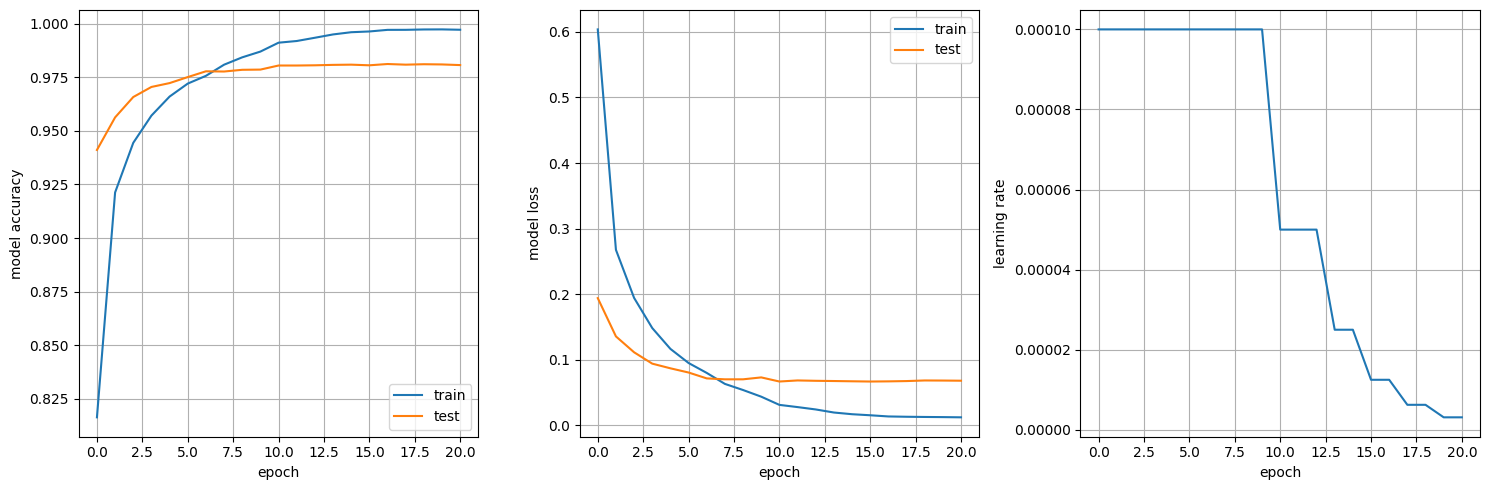

In [10]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save_model_path='./saved_models/model_DNN.keras' # al posto di .h5 perhé considerato obsoleto
model_DNN.save(filepath=save_model_path, include_optimizer=True)

figure, axes = plt.subplots(1,3, figsize=(15,5))

# summarize history for accuracy
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_ylabel('model accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='lower right')
axes[0].grid(True)

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_ylabel('model loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='best')
axes[1].grid(True)

axes[2].plot(history.history['learning_rate'])
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("learning rate")
axes[2].grid(True)

plt.tight_layout()
plt.show()

**Accuratezza**

Nel primo grafico a sinistra troviamo l'accuratezza del sul training set e su quello di validation in funzione delle epoche:

+ L’accuratezza sull'insieme di training cresce rapidamente nelle prime epoche e continua a salire fino a sfiorare il 99.9%, indicando un apprendimento efficace.

- L’accuratezza sul test set segue un andamento simile, ma si stabilizza attorno al 98%, ossia il modello generalizza bene e non mostra overfitting evidente.

+ La distanza tra le due curve è piccola, a conferma della buona capacità di generalizzazione.

**Loss**

Il secondo grafico mostra l'andamento della loss per il training e il test:
+ La loss di training si avvicina molto a zero, in accordo con l'andamento dell'accuratezza

- La loss di validazione decresce fino a stabilizzarsi fino ad un valore minimo, comportamento che ha attivato la funzione ReduceLROnPlateau, che ha permesso di continuare l'allenamento con un LR più basso, andando a migliorare leggermente la loss

+ L’inversione che si osserva tra le due loss è influenzata da due comportamenti simultanei:
    1. Influenza dal layer di Dropout: durante l'allenamento, il layer Dropout disattiva casualmente una frazione dei neuroni, questo riduce la capacità del modello, rendendolo più "debole" per prevenire overfitting. Durante il test, Dropout si disattiva, e il modello usa tutti i neuroni, risultando più preciso. 
    2. All'inizio il modello non ha ancora imparato ad ottimizzare la loss di training, la quale, andando avanti con le epoche, continua a scendere, mentre quella di test si stabilizza ad un valore.


**Learning rate**

Nel terzo e ultimo grafico vediamo come varia il learning rate in funzione delle epoche di training:
* Da un LR iniziale di $10^{-4}$, non appena non si sono hanno avuto miglioramenti significativi sulla loss, è stata chiamata la funzione ReduceLROnPlateau, che ha dimezzato il LR.

+ ReduceLROnPlateau è stata chiamata diverse volte riducendo il LR fino a $3.125 \cdot 10^{-6}$

* Questo meccanismo ci permette di raffinare l’apprendimento nelle fasi finali, cercando il minimo assoluto della loss.

##### **Predizione sul dataset MNIST e su cifre disegnate a mano**

Per verificare l'accuratezza del modello, sono state visualizzate le predizioni su 10 cifre prese dal set di test MNIST. In ogni subplot viene mostrata l'immagine della cifra, l'etichetta e la predizione del modello:

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


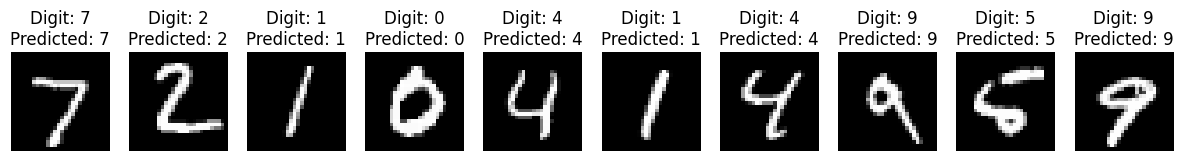

In [11]:
import keras
save_model_path='./saved_models/model_DNN.keras'
model_old = keras.models.load_model(save_model_path)
predictions = model_old.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Per testare ulteriormente la capacità di generalizzazione del modello, ho realizzato manualmente 10 cifre da 0 a 9, nello stesso stile di quelle del MNIST. Queste immagini sono state modificate per adattarle al formato richiesto dal modello:
* Convertite in scala di grigi (0-255);
* Normalizzate tra 0 e 1 (val/255);
* Appiattite in vettori compatibili con l’input della rete (1, img_rows $\times$ img_cols).

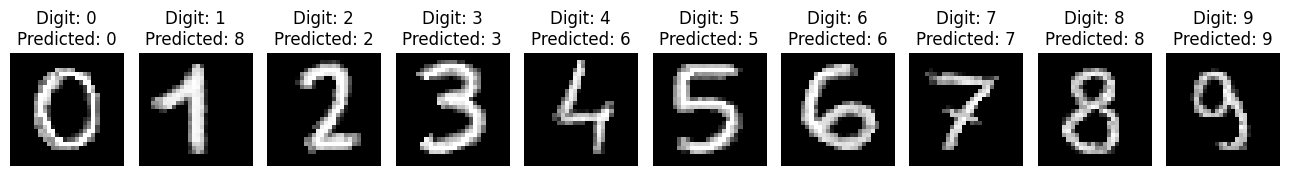

In [12]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

def predict_my_number(index):
    digit_filename = f"my_numbers/{index}.png"
    digit_in = Image.open(digit_filename).convert('L')
    width, height = digit_in.size

    pix = digit_in.load()
    data = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            data[y, x] = pix[x, y]

    data /= 255.0
    data_flat = data.reshape(1, -1)

    pred = model_old.predict(data_flat, verbose=0)

    ax = plt.subplot(2, 10, index + 1)  
    plt.imshow(data, cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(index, np.argmax(pred)))
    plt.axis('off') 

plt.figure(figsize=(13, 13)) 
for i in range(10):
    predict_my_number(i)

plt.tight_layout()
plt.show()


Il modello addestrato è stato in grado di predire correttamente la maggior parte delle cifre disegnate, tranne per qualche cifra, forse dovuto a delle differenze di grafia rispetto allo stile dei campioni MNIST.

Nel complesso, il risultato dimostra che la rete neurale è sufficientemente generalizzabile, ma evidenzia anche i limiti di una DNN (fully connected) rispetto, ad esempio, a una rete convoluzionale (CNN), più adatta a questo genere di problemi.